# data preprocessing

In [5]:
!pip install -q imbalanced-learn

# import libraries

In [24]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model


In [3]:
# load data
df = pd.read_csv('/content/final-v1.csv')

# Display basic info and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   edge_followed_by      785 non-null    float64
 1   edge_follow           785 non-null    float64
 2   username_length       785 non-null    int64  
 3   username_has_number   785 non-null    int64  
 4   full_name_has_number  785 non-null    int64  
 5   full_name_length      785 non-null    int64  
 6   is_private            785 non-null    int64  
 7   is_joined_recently    785 non-null    int64  
 8   has_channel           785 non-null    int64  
 9   is_business_account   785 non-null    int64  
 10  has_guides            785 non-null    int64  
 11  has_external_url      785 non-null    int64  
 12  is_fake               785 non-null    int64  
dtypes: float64(2), int64(11)
memory usage: 79.9 KB


(None,
    edge_followed_by  edge_follow  username_length  username_has_number  \
 0             0.001        0.257               13                    1   
 1             0.000        0.958                9                    1   
 2             0.000        0.253               12                    0   
 3             0.000        0.977               10                    1   
 4             0.000        0.321               11                    0   
 
    full_name_has_number  full_name_length  is_private  is_joined_recently  \
 0                     1                13           0                   0   
 1                     0                 0           0                   1   
 2                     0                 0           0                   0   
 3                     0                 0           0                   0   
 4                     0                11           1                   0   
 
    has_channel  is_business_account  has_guides  has_external_url  is_

/tmp/ipython-input-4-1383300163.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")


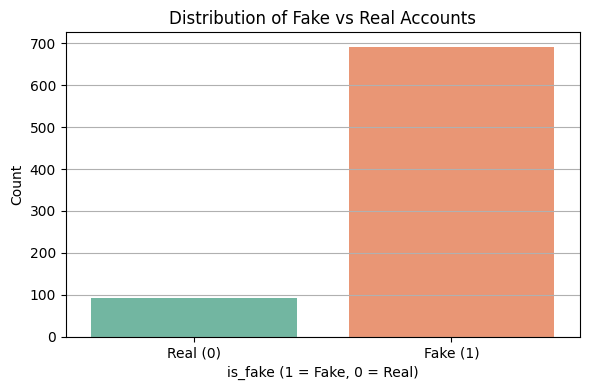

{1: 692, 0: 93}

In [4]:
# Check class balance
class_counts = df['is_fake'].value_counts()

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Distribution of Fake vs Real Accounts")
plt.xlabel("is_fake (1 = Fake, 0 = Real)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Real (0)", "Fake (1)"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Show class counts for decision-making
class_counts.to_dict()

# Data Augmentation

In [8]:
# Separate features and target
X = df.drop(columns=['is_fake'])
y = df['is_fake']

# Apply SMOTE to balance classes (focus on minority class = real accounts)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Combine the new dataset
smote_df = pd.DataFrame(X_smote, columns=X.columns)
smote_df["is_fake"] = y_smote

# Check the new class distribution
smote_df.shape, smote_df['is_fake'].value_counts().to_dict()

((1384, 13), {1: 692, 0: 692})

/tmp/ipython-input-10-3429340617.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")


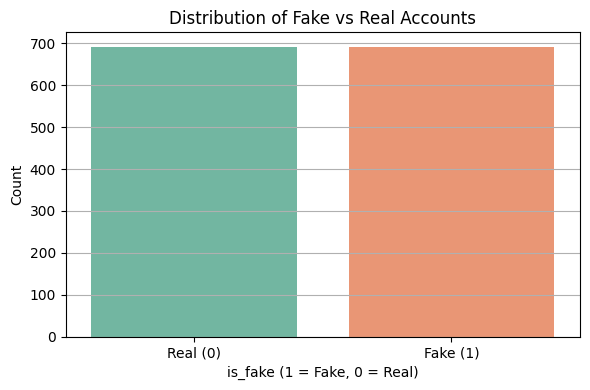

{1: 692, 0: 692}

In [10]:
# Check class balance
class_counts = smote_df['is_fake'].value_counts()

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Distribution of Fake vs Real Accounts")
plt.xlabel("is_fake (1 = Fake, 0 = Real)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Real (0)", "Fake (1)"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Show class counts for decision-making
class_counts.to_dict()

# Split Dataset into Train, Validation, and Test

In [12]:
# Step 1: Separate features (X) and target label (y)
X = smote_df.drop(columns=["is_fake"])
y = smote_df["is_fake"]

# Step 2: First split — 60% train, 40% temporary (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 3: Second split — split the temporary 40% into 50/50 = 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


# Train a Random Forest Model

In [15]:
#  Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Validate on validation set
val_preds = rf_model.predict(X_val)
print("Validation Performance:")
print("Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report:\n", classification_report(y_val, val_preds))

# Final evaluation on test set
test_preds = rf_model.predict(X_test)
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, test_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, test_preds))

Validation Performance:
Accuracy: 0.9819494584837545

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       138
           1       0.99      0.97      0.98       139

    accuracy                           0.98       277
   macro avg       0.98      0.98      0.98       277
weighted avg       0.98      0.98      0.98       277


Test Set Performance:
Accuracy: 0.9566787003610109

Confusion Matrix:
 [[138   1]
 [ 11 127]]


#Build Neural Network with Keras

In [17]:
#  Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.5001 - loss: 0.7235 - val_accuracy: 0.8881 - val_loss: 0.5207
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8168 - loss: 0.5223 - val_accuracy: 0.9206 - val_loss: 0.3639
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8868 - loss: 0.3882 - val_accuracy: 0.9170 - val_loss: 0.2688
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9038 - loss: 0.3026 - val_accuracy: 0.9097 - val_loss: 0.2254
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8833 - loss: 0.2968 - val_accuracy: 0.9170 - val_loss: 0.2051
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8911 - loss: 0.2611 - val_accuracy: 0.9206 - val_loss: 0.1949
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9069 - loss: 0.2510 - val_accuracy: 0.9278 - val_loss: 0.1898
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9073 - loss: 0.2310 - val_accuracy: 0.9314 - val_loss

# Evaluate on Test Set

In [18]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nNeural Network Test Accuracy: {test_accuracy:.4f}")


Neural Network Test Accuracy: 0.9314


# Plot Accuracy Over Epochs

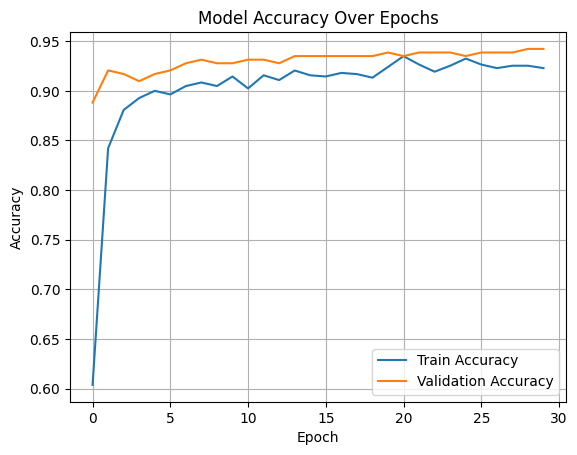

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#Save the Model

In [23]:
model.save("account_classification_model.h5")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [27]:
model = load_model("account_classification_model.h5")
scaler = joblib.load("scaler.pkl")
new_account = np.array([[150, 300, 8, 1, 12, 0, 0, 1, 0, 0, 0, 0]])

new_data_scaled = scaler.transform(new_account)

# Predict
prediction = model.predict(new_data_scaled)
predicted_label = int(prediction[0][0] > 0.5)
print("Prediction score:", prediction[0][0])
print("Result:", "Fake (Reject)" if predicted_label else "Real (Accept)")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Prediction score: 0.0
Result: Real (Accept)
